In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
import scipy.stats.distributions as dist

from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA , TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix

from collections import defaultdict , Counter
import string
import re


from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding , LSTM , Dense , SpatialDropout1D , Dropout
from keras.initializers import Constant
from keras.optimizers import Adam


plt.style.use('ggplot')
stop = set(stopwords.words('english'))


In [2]:
dataset = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
dataset.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [3]:
dataset.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [4]:
print('Number of rows in Training {}'.format(dataset.shape[0]))
print('Number of rows in Test {}'.format(test.shape[0]))

Number of rows in Training 7613
Number of rows in Test 3263


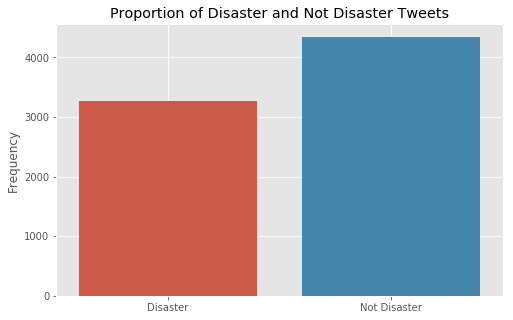

In [5]:
# Number of real and not real dataset in training

real = dataset[dataset.target == 1].shape[0]
not_real = dataset[dataset.target == 0].shape[0]
plt.figure(figsize = (8,5))
sns.barplot(x = ['Disaster' , 'Not Disaster']  , y = [real , not_real]).set(title = 'Proportion of Disaster and Not Disaster Tweets' , ylabel = 'Frequency')
plt.grid(alpha = 1)

In [6]:
dataset['length'] = dataset['text'].apply(lambda x : len(x))

In [7]:
dataset.length.head()

0     69
1     38
2    133
3     65
4     88
Name: length, dtype: int64

The distribution of length of tweet is skewed right, centered around 125 with most lengths between 90 to 140, a range of rough 120, and some outliers are present below 15 

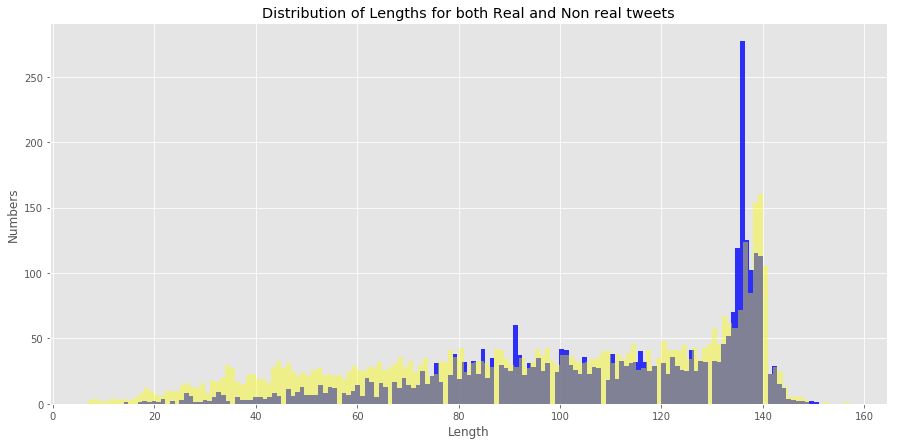

In [8]:
plt.figure(figsize = (15,7))
sns.distplot(dataset[dataset.target == 1]['length'] , bins = 150 , color = 'blue' , kde = False , hist_kws = {'alpha':0.8})
sns.distplot(dataset[dataset.target == 0]['length'] , bins = 150, color = 'yellow',kde = False , hist_kws = {'alpha':0.4}).set(ylabel = 'Numbers' , xlabel = 'Length', title = 'Distribution of Lengths for both Real and Non real tweets')
plt.show()

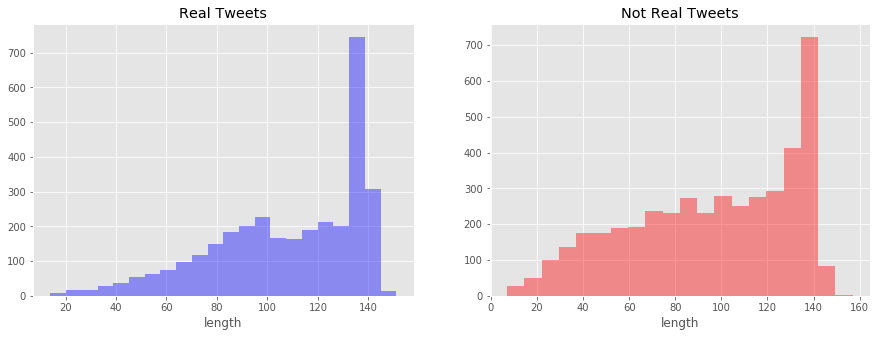

In [9]:
plt.figure(figsize = (15,5))
plt.subplot(121)
plt.title('Disaster Tweets')
sns.distplot(dataset[dataset.target == 1]['length'] , kde = False , color= 'blue').set(title = 'Real Tweets')

plt.subplot(122)
sns.distplot(dataset[dataset.target == 0]['length'] , kde = False , color = 'red').set(title = 'Not Real Tweets')

plt.show()

Five point summary for both the categories is almost similar.

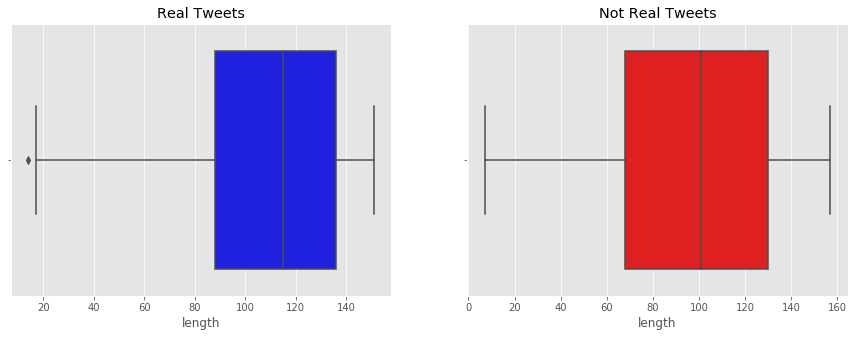

In [10]:
plt.figure(figsize = (15,5))
plt.subplot(121)
sns.boxplot(dataset[dataset.target == 1]['length']  ,color= 'blue').set(title = 'Real Tweets')

plt.subplot(122)
sns.boxplot(dataset[dataset.target == 0]['length'] , color = 'red').set(title = 'Not Real Tweets')

plt.show()

Research Question: What is the average length for real tweet?

Target Population: Tweets 
Parameter of Interest: Real Tweets Length

In [11]:
mean1 = dataset[dataset.target == 1]['length'].mean()
mean2 = dataset[dataset.target == 0]['length'].mean()

std1 = dataset[dataset.target == 1]['length'].std()
std2 = dataset[dataset.target == 0]['length'].std()

len1 = dataset[dataset.target == 1]['length'].shape[0]
len2 = dataset[dataset.target == 0]['length'].shape[0]
((mean1 , std1 , len1) , (mean2 , std2 , len2))

((108.11342097217977, 29.309854313585124, 3271),
 (95.70681713496084, 35.88592390140917, 4342))

###### From the given sample of data, with 95% confidence we estimate that the length of text for real tweet is between 107.10 to 109.11

In [12]:
Margin_of_error = 1.96* std1/np.sqrt(len1)

lcb = mean1 - Margin_of_error
ucb = mean1 + Margin_of_error
(lcb , ucb)

(107.10896834491531, 109.11787359944422)

###### From the given sample of data, with 95% confidence we estimate that the length of text for non real tweet is between 94.63 to 96.77

In [13]:
Margin_of_error = 1.96* std2/np.sqrt(len2)

lcb = mean2 - Margin_of_error
ucb = mean2 + Margin_of_error
(lcb , ucb)

(94.63939723862198, 96.7742370312997)

Research Question: Is there a significant difference between the length of text of real and not real tweet.

Hypotheses: 

$H_0$: mu1 - mu2 = 0

$H_1$: mu1 - mu2 != 0

1:real, 0:Not Real

alpha = 0.05, probability of type1 error

As we can see our p_val is less than 0.05, that means we have enough evidence to reject the NULL hypotheses and go with Alternative which states that there is clearly difference between the length of real and non real tweet

In [14]:
estimated_standard_error = np.sqrt(std1**2/len1 + std2**2/len2)
test_statistic = (mean1 - mean2)/estimated_standard_error
p_val = 2*dist.norm.cdf(-np.abs(test_statistic))
(test_statistic , p_val)

(16.59053836593359, 8.15857507373701e-62)

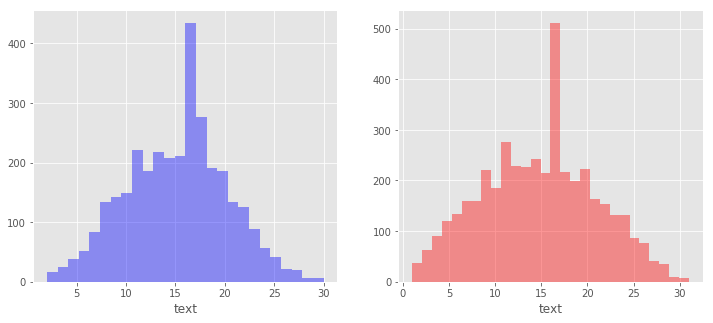

In [15]:
plt.figure(figsize = (12,5))
plt.subplot(121)
words = dataset[dataset.target == 1]['text'].str.split().map(lambda x : len(x))
sns.distplot(words , kde = False , color = 'blue')

plt.subplot(122)
words = dataset[dataset.target == 0]['text'].str.split().map(lambda x : len(x))
sns.distplot(words , kde = False , color = 'red')

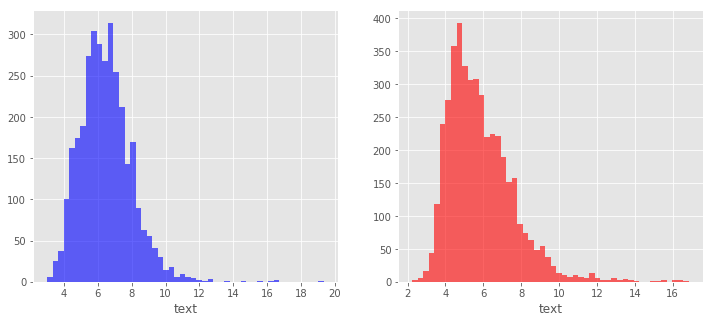

In [16]:
plt.figure(figsize = (12,5))
plt.subplot(121)
words = dataset[dataset.target == 1]['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x : np.mean(x))
sns.distplot(words , color = 'blue' , hist_kws={'alpha':0.6} , kde = False)

plt.subplot(122)
words = dataset[dataset.target == 0]['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x : np.mean(x))
sns.distplot(words , color = 'red' , hist_kws = {'alpha': 0.6} , kde = False)

In [54]:
def create_corpus(target):
    corpus = []
    
    for x in dataset[dataset.target == target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

def create_corpus_df(tweet , target):
    corpus = []
    
    for x in tweet[tweet.target == target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

#### Analyze not real tweets

[Text(0.5,1,'Frequency of Top 15 words in non real tweets')]

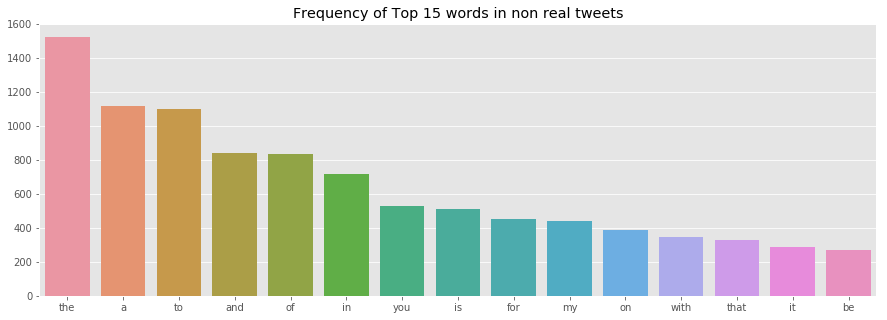

In [18]:
corpus = create_corpus(0)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
top = sorted(dic.items() , key = lambda x:x[1] , reverse=True)[:15]

plt.figure(figsize = (15,5))
x , y = zip(*top)
sns.barplot(list(x) , list(y)).set(title = 'Frequency of Top 15 words in non real tweets')

In [19]:
np.array(stop)

array({'again', 'd', 'because', 't', 'had', 'on', 'before', 'after', 'from', 'which', 'own', 'll', 'ain', 'under', 'hasn', 'an', 'few', 'to', 'no', "didn't", 're', 'off', "needn't", 'do', 'needn', 's', 'this', 'hadn', 'when', 'both', 'ours', 'while', 'further', 'am', 'but', 'until', 'all', 'my', 'here', "she's", "you're", 'don', 'being', 'as', 'there', "you've", 'she', 'their', 'through', 'weren', 'whom', 'he', 'such', 'himself', "hasn't", 'were', "you'll", 'ourselves', 'your', 'with', 'myself', 'themselves', "wasn't", 'for', 'the', 'other', 'those', 'each', "mustn't", 'during', 'below', 'at', 'wasn', 'about', 'then', 'up', 'have', 'if', "mightn't", "hadn't", 'it', 'did', 'than', 'won', 'can', 'will', 'most', 'just', "should've", 'against', 'so', 'its', 'i', 'yours', 'me', 'doesn', 'between', 'our', 'itself', 'are', 'only', "it's", 'o', 'mustn', 'didn', 'into', 'and', 'should', "isn't", "aren't", 'haven', 'ma', 'over', 'who', 'more', 'herself', 'be', "don't", "shan't", 'any', 'nor', "s

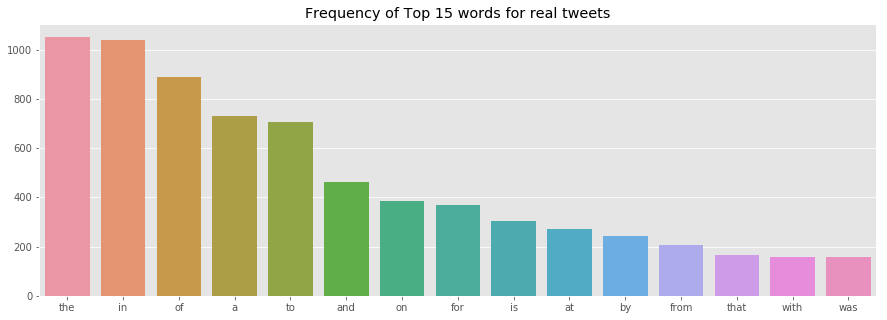

In [20]:
plt.figure(figsize = (15,5))
corpus = create_corpus(1)

dic = defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word] += 1
top = sorted(dic.items() , key = lambda x:x[1] , reverse = True)[:15]

x, y = zip(*top)
sns.barplot(list(x) , list(y)).set(title = 'Frequency of Top 15 words for real tweets')
plt.show()

In [21]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

##### Analyze Punctuation

Let's first do it for real tweet

[Text(0.5,1,'Barplot for punctuation in real tweet')]

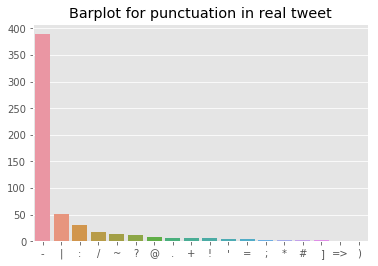

In [22]:
corpus = create_corpus(1)
dic = defaultdict(int)
punctuation = string.punctuation

for word in corpus:
    if word in punctuation:
        dic[word] += 1
        
top = sorted(dic.items() , key = lambda x:x[1] , reverse = True)

x,y = zip(*top)
sns.barplot(list(x) , list(y)).set(title = 'Barplot for punctuation in real tweet')

[Text(0.5,1,'Barplot for punctuation in not real tweet')]

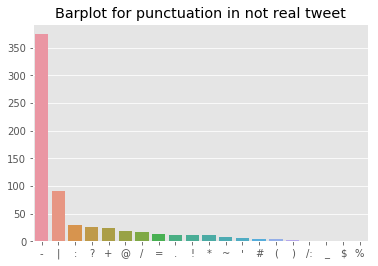

In [23]:
corpus = create_corpus(0)
dic = defaultdict(int)
punctuation = string.punctuation

for word in corpus:
    if word in punctuation:
        dic[word] += 1
        
top = sorted(dic.items() , key = lambda x:x[1] , reverse = True)

x,y = zip(*top)
sns.barplot(list(x) , list(y)).set(title = 'Barplot for punctuation in not real tweet')

In [26]:
def get_top_tweet_bigrams(corpus,n = None):
    vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_of_words = bag_of_words.sum(axis = 0)
    words_freq = [(word,sum_of_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq , key = lambda x:x[1] , reverse = True)
    return words_freq[:n]


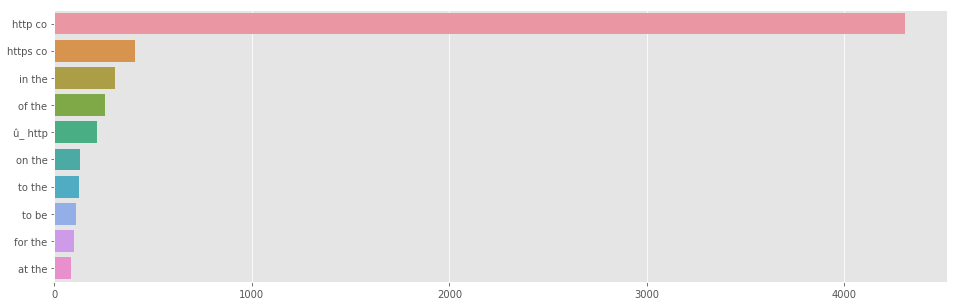

In [27]:
plt.figure(figsize=(16,5))
top_tweet_bigrams=get_top_tweet_bigrams(dataset['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [29]:
df = pd.concat([dataset, test])
df.shape

c:\users\kiit\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(10876, 6)

In [30]:
example = 'New Competition Launched :https://www.kaggle.com/c/nlp-getting-started'

In [33]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.S+')
    return url.sub(r'',text)

In [34]:
remove_url(example)

'New Competition Launched :'

In [35]:
df['text'] = df['text'].apply(lambda x:remove_url(x))

In [36]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [38]:
def remove_html_tag(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

In [41]:
print(remove_html_tag(example))


Real or Fake
Kaggle 
getting started



In [39]:
df['text'] = df['text'].apply(lambda x: remove_html_tag(x))

In [42]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [43]:
df['text'] = df['text'].apply(lambda x: remove_emoji(x))

In [50]:
def remove_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

example = "I am a &^#King"
remove_punct(example)

'I am a King'

In [51]:
df['text'] = df['text'].apply(lambda x:remove_punct(x))

### WordCloud

In [55]:
corpus_new1 = create_corpus_df(df,1)
len(corpus_new1)

46270

In [56]:
corpus_new1[:10]

['Our',
 'Deeds',
 'are',
 'the',
 'Reason',
 'of',
 'this',
 'earthquake',
 'May',
 'ALLAH']

###### Disaster

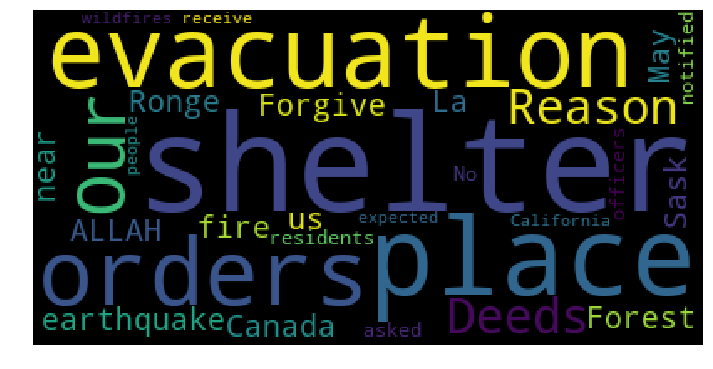

In [61]:
plt.figure(figsize = (12,8))
word_cloud = WordCloud(background_color='black',max_font_size=80).generate(" ".join(corpus_new1[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [62]:
corpus_new0 = create_corpus_df(df , 0)
len(corpus_new0)

60479

In [63]:
corpus_new0[:10]

['Whats', 'up', 'man', 'I', 'love', 'fruits', 'Summer', 'is', 'lovely', 'My']

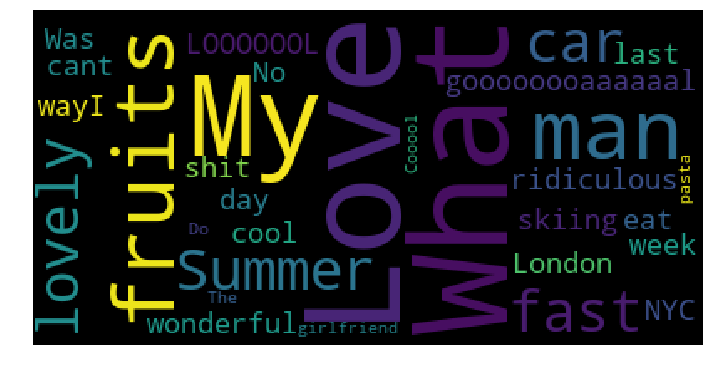

In [66]:
plt.figure(figsize = (12,8))
word_cloud = WordCloud(background_color='black',max_font_size=80).generate(" ".join(corpus_new0[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [67]:
df.head(10)

,id,keyword,length,location,target,text
0,1,NaN,69.0,NaN,1.0,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,38.0,NaN,1.0,Forest fire near La Ronge Sask Canada
2,5,NaN,133.0,NaN,1.0,All residents asked to shelter in place are be...
3,6,NaN,65.0,NaN,1.0,13000 people receive wildfires evacuation orde...
4,7,NaN,88.0,NaN,1.0,Just got sent this photo from Ruby Alaska as s...
5,8,NaN,110.0,NaN,1.0,RockyFire Update California Hwy 20 closed in ...
6,10,NaN,95.0,NaN,1.0,flood disaster Heavy rain causes flash floodin...
7,13,NaN,59.0,NaN,1.0,Im on top of the hill and I can see a fire in ...
8,14,NaN,79.0,NaN,1.0,Theres an emergency evacuation happening now i...
9,15,NaN,52.0,NaN,1.0,Im afraid that the tornado is coming to our area


In [86]:
def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb , count_vectorizer

list_corpus = df['text'].tolist()
list_labels = df['target'].tolist()

X_train , X_test , y_train , y_test = train_test_split(list_corpus , list_labels , test_size = 0.2 , random_state = 50)

X_train_counts , count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

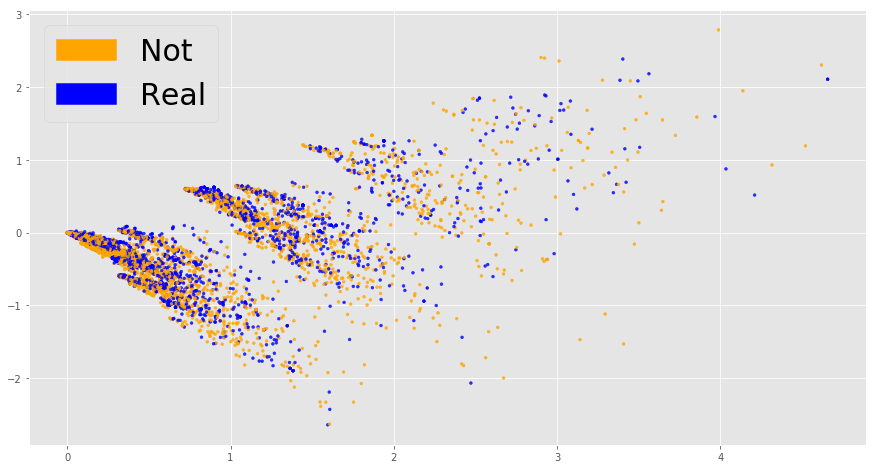

In [87]:
def plot_lsa(test_data , test_labels , plot = True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ['orange','blue']
    if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Not')
            blue_patch = mpatches.Patch(color='blue', label='Real')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})

fig = plt.figure(figsize=(15, 8))          
plot_lsa(X_train_counts, y_train)
plt.show()

##### TFIDF

In [88]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    
    train = tfidf_vectorizer.fit_transform(data)
    return train,tfidf_vectorizer

X_train_tfidf , tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

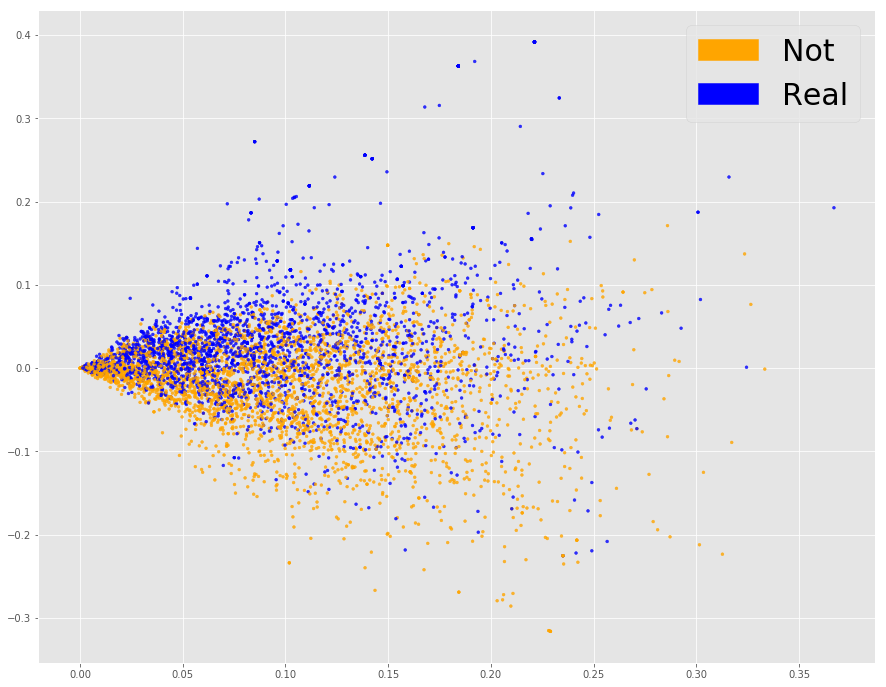

In [89]:
fig = plt.figure(figsize=(15, 12))          
plot_lsa(X_train_tfidf, y_train)
plt.show()

In [119]:
def corpus_create_new(df):
    corpus = []
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [120]:
corpus = corpus_create_new(df)

100%|██████████████████████████████████████████████████████████████████████████| 10876/10876 [00:01<00:00, 6251.64it/s]


In [115]:
embedding_dict = {}
with open('glove.6B.100d.txt','r' , encoding='utf8') as fh:
    for line in fh:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors
    fh.close()

In [121]:
MAX_LEN = 50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)

tweet_pad = pad_sequences(sequences ,maxlen=MAX_LEN,truncating = 'post',padding = 'post')


In [122]:
word_index = tokenizer_obj.word_index
print('Number of Unique Words {} '.format(len(word_index)))

Number of Unique Words 20343 


In [125]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec

100%|████████████████████████████████████████████████████████████████████████| 20343/20343 [00:00<00:00, 338233.16it/s]


In [126]:
tweet_pad[0][0:]

array([ 622, 5467,  738,  175,   80, 1805, 3529,   16,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [142]:
model = Sequential()
embedding = Embedding(num_words,100,embeddings_initializer = Constant(embedding_matrix) , input_length=MAX_LEN , trainable = False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100,dropout = 0.2 , recurrent_dropout=0.2))
model.add(Dense(1 , activation = 'sigmoid'))
optimizer=Adam(lr=3e-4)

model.compile(loss = 'binary_crossentropy',optimizer = optimizer , metrics = ['accuracy'])


In [143]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 100)           2034400   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 2,114,901
Trainable params: 80,501
Non-trainable params: 2,034,400
_________________________________________________________________


In [144]:
train_tweet = tweet_pad[:dataset.shape[0]]
test = tweet_pad[dataset.shape[0]:]

In [145]:
X_train,X_test,y_train,y_test = train_test_split(train_tweet,dataset['target'].values , test_size = 0.2)
print('Shape of train ',X_train.shape)
print('Shape of Validation ',X_test.shape)

Shape of train  (6090, 50)
Shape of Validation  (1523, 50)


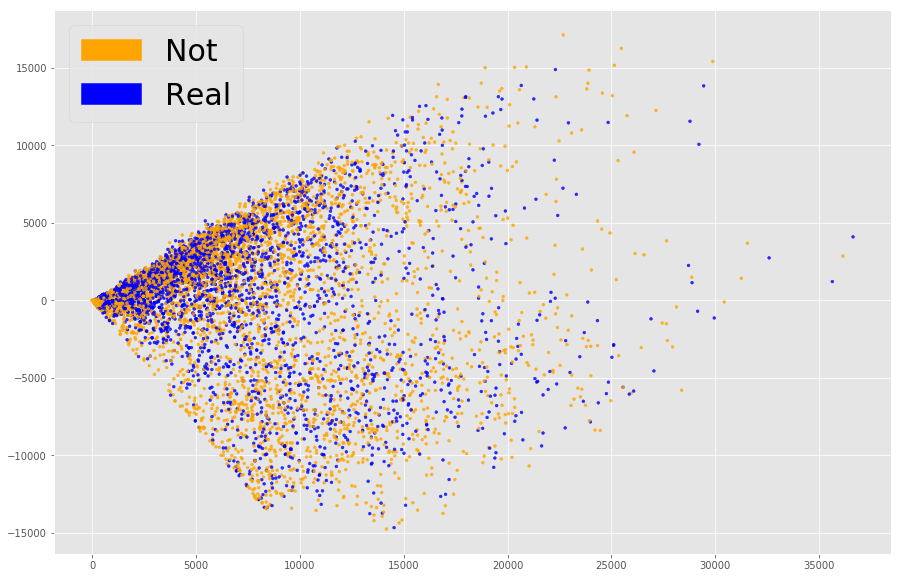

In [146]:
plt.figure(figsize = (15,10))
plot_lsa(train_tweet , dataset['target'])


In [148]:
history=model.fit(X_train,y_train,batch_size=4,epochs=10,validation_data=(X_test,y_test),verbose=2)

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
 - 40s - loss: 0.5607 - acc: 0.7379 - val_loss: 0.5178 - val_acc: 0.7577
Epoch 2/10
 - 51s - loss: 0.5195 - acc: 0.7624 - val_loss: 0.5265 - val_acc: 0.7728
Epoch 3/10
 - 49s - loss: 0.5081 - acc: 0.7704 - val_loss: 0.4816 - val_acc: 0.7905
Epoch 4/10
 - 47s - loss: 0.4900 - acc: 0.7862 - val_loss: 0.4893 - val_acc: 0.7905
Epoch 5/10
 - 50s - loss: 0.4995 - acc: 0.7819 - val_loss: 0.4701 - val_acc: 0.7886
Epoch 6/10
 - 50s - loss: 0.4826 - acc: 0.7841 - val_loss: 0.4638 - val_acc: 0.7958
Epoch 7/10
 - 47s - loss: 0.4791 - acc: 0.7826 - val_loss: 0.4929 - val_acc: 0.7814
Epoch 8/10
 - 46s - loss: 0.4711 - acc: 0.7974 - val_loss: 0.4877 - val_acc: 0.7814
Epoch 9/10
 - 48s - loss: 0.4704 - acc: 0.7901 - val_loss: 0.4623 - val_acc: 0.7912
Epoch 10/10
 - 46s - loss: 0.4615 - acc: 0.7957 - val_loss: 0.4526 - val_acc: 0.7919


In [160]:
train_pred_glove = model.predict(train_tweet)
train_pred_glove_int = train_pred_glove.round().astype('int')
train_pred_glove_int.shape

(7613, 1)

#### Making Submission

In [164]:
sample_sub = pd.read_csv('sample_submission.csv')

In [165]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

In [166]:
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
